# Deep Learning with Python - Ch. 5.3 Notes

**Classifying photos with dogs or cats using convnets using pre-trained models.**

In the last section (`5.2`), we trained a neural network using data augmentation & a dropout layer (to battle overfitting on such a small dataset). 

That model is saved as `cats_and_dogs_small_2.h5`. We'll load that here.

In [4]:
from keras import models, layers
model = models.load_model('cats_and_dogs_small_2.h5')

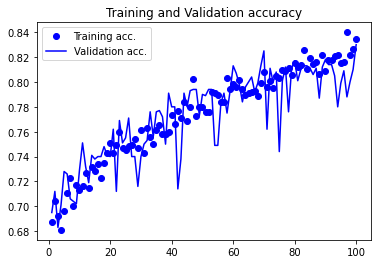

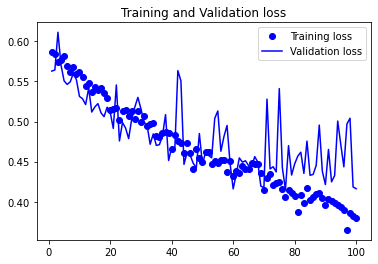

In [77]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc.')
plt.plot(epochs, val_acc, 'b', label='Validation acc.')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.legend()

plt.show()

# Pre-trained models

See notes for how they work (`dlwp_p2_convnets.txt`).

We'll be using the `VGG16` pre-trained model. We'll use only the convolutional base.

You pass three arguments to the `VGG16` constructor:
1. `weights`: the weight checkpoint from which to instantiate the model
2. `include_top`: refers to including (or not) the densely connected classifier on top of the network. We will not be including this (see notes for reason)
3. `input_shape` is the shape of the original tensors we'll feed to the network



In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Now we have two choices. We will cover both.

**Option 1: Fast feature extraction without data augmentation**

Running the convolutional base on your dataset, recording its output to a numpy array on disk. Then, use this data as input to a standalone, densely connected classifier.

This is much faster, since we only have to run the convolutional base once for each of our images.

But for that reason, we can't use data augmentation.

**Option 2: Feature extraction with data augmentation**

Extending the model you have (`conv_base`, in our case) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. Doing this allows us to use data augmentation, because every input image goest through the convolutional base every time it's seen by the model. Because of that, it's far more expensive than the first option.

## Option 1: Fast feature extraction without data augmentation

In [24]:
%%time
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/cats-vs-dogs-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    """
    Extracts features by calling the `.predict` method of the `conv_base` model.
    
    Parameters:
    ------------
    `directory`: base image directory
    `sample_count`: num samples to process. Necessary to tell generator to stop yielding.
    """    
    
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # shape of the output of the last layer of the conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
        # Since generators yield data indefinitely in a loop, we must `break` after every image has been seen once.
            break
    return features, labels
    

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 18min 50s, sys: 58.1 s, total: 19min 48s
Wall time: 2min 14s


In [25]:
train_features.shape

(2000, 4, 4, 512)

Our final feature maps have shape `(samples, 4, 4, 512)`. We're feeding these into a densely connected classifier, so we must first flatten them. 

In [26]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Adding the densely connected classifier

In [27]:
from keras import models, layers, optimizers


model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.6481 - acc: 0.6137 - val_loss: 0.4406 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 0.4303 - acc: 0.8033 - val_loss: 0.3640 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 1s 15ms/step - loss: 0.3546 - acc: 0.8461 - val_loss: 0.3259 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 0.3156 - acc: 0.8634 - val_loss: 0.3028 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2930 - acc: 0.8784 - val_loss: 0.2835 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2719 - acc: 0.8827 - val_loss: 0.2755 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2604 - acc: 0.9027 - val_loss: 0.2755 - val_acc: 0.8840
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

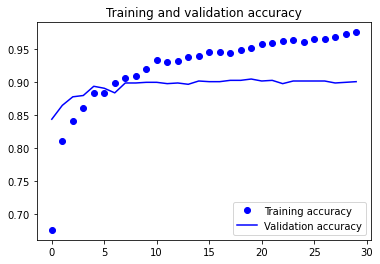

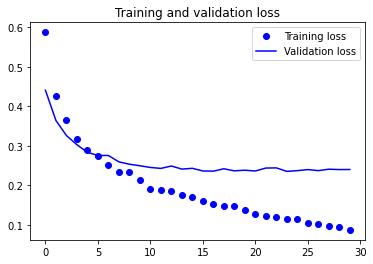

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()